In [16]:
import sys
import numpy as np
from matplotlib import pyplot as plt

use_devel = True

# insert the mymujoco path for TrainDQN.py file
if use_devel:
  sys.path.insert(0, "/home/luke/mujoco-devel/rl")
else:
  sys.path.insert(0, "/home/luke/mymujoco/rl")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData
data_explorer = GraspTestData()

# enter folder and load test data
test_name = "op-curriculum-test"
saver.enter_folder(test_name)
try:
  testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
  print(data_explorer.get_test_string(data=testdata, detailed=True))
except TypeError as e:
  print("Loading test data failed, check that the test has actually saved some data")
  print("Error was:", e)

Loading file /home/luke/gripper-ros/test_data/op-curriculum-test/test_data_004.lz4 with pickle ... finished
Test information

Test name: op-curriculum-test
Finger width: 0.028
Finger thickness: 0.0009
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: True
Loaded group name: 24-07-23
Loaded run name: operator-PC_15:10_A2
Loaded best SR: 0.877

Results information:

num_sphere = 0
num_cuboid = 0
num_cylinder = 0
num_cube = 0
sphere_SR = 0.0000
cylinder_SR = 0.0000
cuboid_SR = 0.0000
cube_SR = 0.0000
avg_steps = 79.7500
avg_stable_height = 0.0000
avg_target_height = 0.0000
avg_lifted = 0.0000
avg_exceed_bending = 0.0000
avg_exceed_axial = 0.0000
avg_exceed_limits = 0.0000
avg_loop = 0.0000
avg_dropped = 0.0000
avg_out_of_bounds = 0.0000
avg_exceed_palm = 0.0000

Sphere success rate: 0.0000
cylinder success rate: 0.0000
cuboid success rate: 0.0000
cube success rate: 0.0000

Total number of trials: 4
Total number of objects: 1
Overall success r

In [2]:
# optionally also print trial information
print_trials = True
_ = data_explorer.get_test_results(data=testdata, print_trials=print_trials)

# print(testdata.trials[-1].steps[-1].SI_state)

Object num = 0, num trials = 3, TH = 0 SH = 0


In [3]:
save = False

if False:

  # edit test name
  testdata.test_name = "heuristic_EI1_S3_real_objects"

  # edit individual trials to fix errors
  for trial in testdata.trials:

    # if trial.object_num in [0]:
    #   trial.object_num = 7
    #   trial.trial_num = 1
    #   trial.object_name = "sideways tin"

    # if trial.object_num in [1]:
    #   if trial.object_name != "kale bag":
    #     trial.object_name = "kale bag"

    if trial.object_num in [4]:
      print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, name = {trial.object_name}, sh = {trial.stable_height}")
      if trial.trial_num == 6:
        trial.stable_height = 1

    # if trial.object_num == 11:
    #   if trial.object_name == "upright tin":
    #     trial.object_name = "sliced meat"
    #   print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, name = {trial.object_name}")


  # for trial in testdata.trials:
  #   if trial.object_num == 1: trial.object_num = 2
  # for trial in testdata.trials:
  #   if trial.object_num == 0: trial.object_num = 1

  if save: saver.save("test_data", pyobj=testdata)

  # # visualise data from a specific trial
  # for trial in testdata.trials:
  #   if trial.object_num == 6:
  #     step = 11
  #     if trial.trial_num == 6:
  #       print("Trial 1", trial.steps[step - 1])
  #       data_explorer.print_trial(trial, steps=[i for i in range(0, len(trial.steps))])
  #     elif trial.trial_num == 6:  
  #       # data_explorer.print_trial(trial, steps=[i for i in range(15)])
  #       pass

  # # get info about all exceed axial trials
  # exceed_axial_list = []
  # for trial in testdata.trials:
  #   if trial.exceed_axial:
  #     exceed_axial_list.append(trial.steps[-1].SI_state[4])
  # print(f"Number of trials where exceed_axial=True is {len(exceed_axial_list)}")
  # if len(exceed_axial_list) > 0:
  #   print(f"AVERAGE last step wrist Z is: {np.mean(exceed_axial_list):.2f} N")
  #   print(f"MINIMUM last step wrist Z is: {min(exceed_axial_list):.2f} N")
  # pass

In [4]:
# # deteremine success rate without certain conditions occuring
# from copy import deepcopy
# testcopy = deepcopy(testdata)
# testcopy.trials = []
# loop_num = 0

# for trial in testdata.trials:
  
#   # when talking about fewer sensor performance without dangerous readings/motors skipping steps:
#   # exclucing loop from S1 is justified as it was very common to see action 2 loops (motors skipping causes loop)
#   # excluding loop from S2 is not justified as most loops were actually raise/lower loops with the palm sensor
#   if not trial.exceed_palm and not trial.exceed_axial and not trial.loop:
#     testcopy.trials.append(deepcopy(trial))
#   if trial.loop:
#     loop_num += 1

# print(data_explorer.get_test_string(data=testcopy, detailed=True))


In [21]:
# explore raw network inputs
trial = -1
start_step = 50
num_steps_to_print = "all" # use "all" for every step

# do we load a model? Try to avoid reload
force_reload = False
if "model" not in globals() or force_reload:
  from TrainDQN import TrainDQN
  model = TrainDQN(log_level=0)
  model.modelsaver = saver
  model.load(filestarts="dqn_model", numbered=False)

# print an observation table

# get observation info
info = model.env.mj.debug_observation(testdata.trials[0].steps[0].state_vector)
if info.startswith("INVALID"): print(info)

# parse info to get sensor names and n samples (last element is observation length)
sensor_names = [x.split(" = ")[0] for x in info.split(" | ")][:-1]
sensor_nums = [int(x.split(" = ")[1]) for x in info.split(" | ")][:-1]

# create the row master for the table
sepbig = " || " # seperate sensors
sep = " "     # seperate individual values

# input the sensor value format
sub_head = "{{{0}:{1}}}"
sf = ".3f"
sub_val = sub_head.format(0, sf)

# now create the rows for the table
sub_heading_fields = []
main_headings = sepbig
sub_headings = sepbig
row_string = sepbig
main_idx = 0
sub_idx = 0
for n in sensor_nums:
  sub_width = len(sub_val.format(-1.0) + sep)
  width = n * sub_width - len(sep)
  this_sub = ""
  for i in range(n):
    if i != n - 1:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sep
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sep
    else:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sepbig
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sepbig
    x = n // 2
    xi = i // 2
    if i % 2 == 0: # even
      sub_heading_fields.append(f"X{x-xi}")
    else: sub_heading_fields.append(f"Y{x-xi}-{x-xi-1}")
  main_idx += 1
  sub_idx += n
  main_headings += f"{{{main_idx}:^{width}}}" + sepbig
  sub_headings += this_sub

# print(main_headings)
# print(sub_headings)
# print(row_string)

row_prefix = sepbig + "{0:>4}"

# now input the data
sensor_names.insert(0, "dummy") # not sure why I need this
main_heading_row = main_headings.format(*sensor_names)
print(row_prefix.format("Step") + main_heading_row)

sub_heading_row = sub_headings.format(*sub_heading_fields)
print(row_prefix.format("") + sub_heading_row)

# check if the number of steps to print is too high
if num_steps_to_print == "all":
  num_steps_to_print = 1000
if start_step + num_steps_to_print > len(testdata.trials[trial].steps):
  num_steps_to_print = len(testdata.trials[trial].steps) - start_step

for i in range(start_step, start_step + num_steps_to_print):

  this_row = row_string.format(*testdata.trials[trial].steps[i].state_vector)
  print(row_prefix.format(i) + this_row)

for i in range(start_step, start_step + num_steps_to_print):
  print(testdata.trials[trial].steps[i].SI_state[3]) # raw data

 || Step ||                   Bend gauge 1                   ||                   Bend gauge 2                   ||                   Bend gauge 3                   ||                    Palm gauge                    ||                     Wrist Z                      ||                  Motor state X                   ||                  Motor state Y                   ||                  Motor state Z                   ||                   Base state Z                   || 
 ||      ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   ||   X3    Y3-2    X2    Y2-1    X1    Y1-0    X0   || 
 ||   50 || -0.004 -0.004 -0.003 -0.00

Loading file /home/luke/gripper-ros/test_data/op-curriculum-test/trial_image_batch_005.lz4 with pickle ... finished
There are 16 images


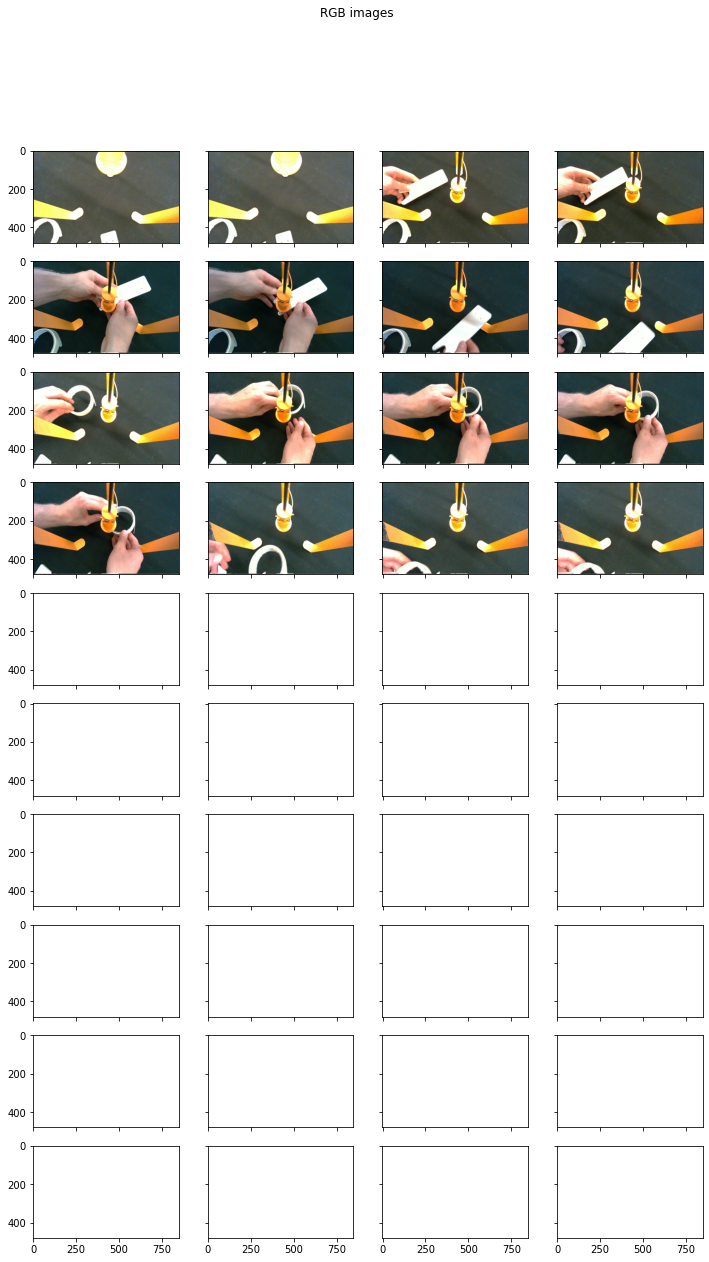

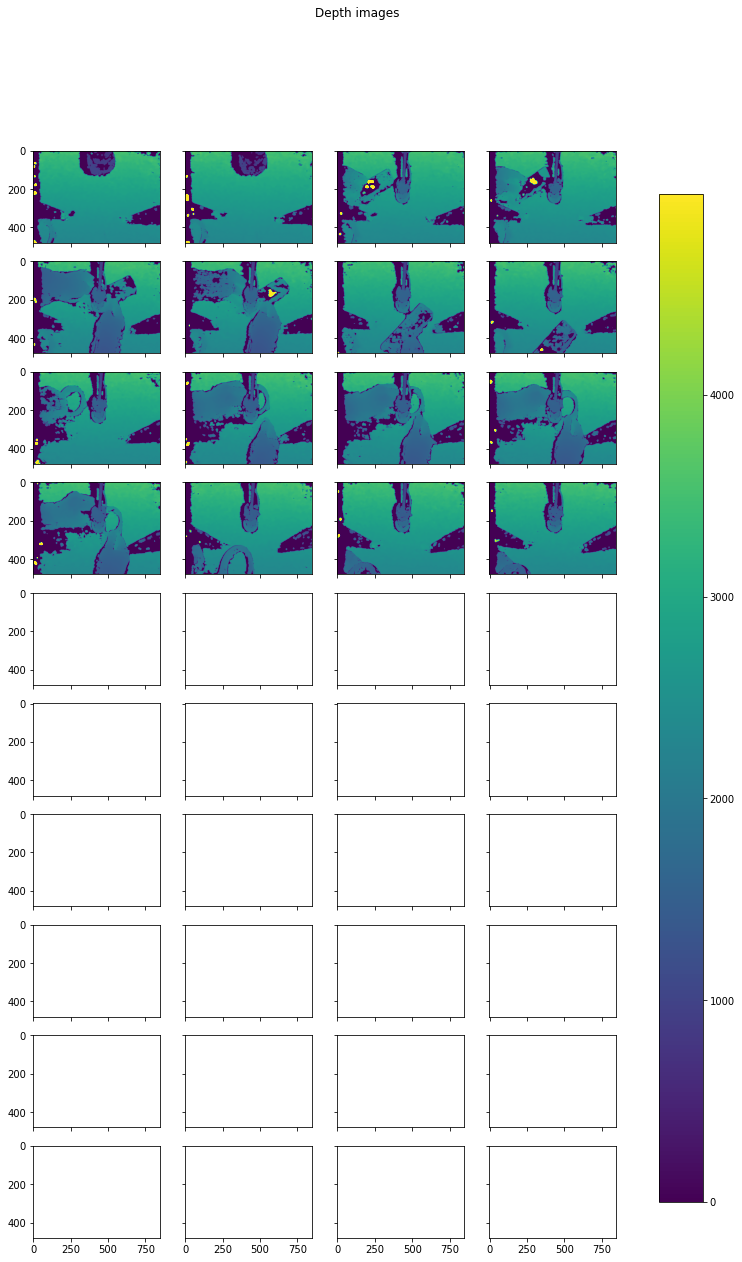

In [6]:
# prepare to load image data
new_test = True
if new_test:
  test_name = "op-curriculum-test"
  saver.enter_folder(test_name)

# extract the image data
imagedata = saver.load(id=5, filenamestarts="trial_image_batch")
image_list = imagedata.trials[0].images
print("There are", len(image_list), "images")

# how many images would we like to plot
rows = 10
cols = 4

num_images = rows * cols
if num_images > len(image_list): num_images = len(image_list)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(rows, cols, sharex=True, sharey=True)

# saturate any values above this (ignore outliers)
depth_max = 5000

# find minimum of minima & maximum of depth data
dmin = 1e10
dmax = -1e10
for i in range(len(image_list)):
  this_min = np.min(image_list[i].depth[image_list[i].depth < depth_max])
  this_max = np.max(image_list[i].depth[image_list[i].depth < depth_max])
  if this_min < dmin: dmin = this_min
  if this_max > dmax: dmax = this_max

for j in range(num_images):
  ix = j // cols
  iy = j % cols
  im1 = axs[ix][iy].imshow(image_list[j].rgb, aspect="auto")
  im2 = axs2[ix][iy].imshow(image_list[j].depth, vmin=dmin, vmax=dmax, aspect='auto', cmap="viridis")

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax)

fig.suptitle("RGB images")
fig2.suptitle("Depth images")

fig.set_size_inches((cols * 3, rows * 2))
fig2.set_size_inches((cols * 3, rows * 2))

fig.savefig("/home/luke/gripper-ros/test_data/demo_rgb_data.png")
fig2.savefig("/home/luke/gripper-ros/test_data/demo_depth_data.png")
plt.show()


In [7]:
im2.get_size()

image_list[-1].rgb.shape

(480, 848, 3)